In [1]:
import numpy as np
from qpsolvers import solve_qp
from scipy.integrate import solve_ivp

In [2]:
from casadi import *

In [3]:
class AAC:
    def __init__(self, m, c_d, f0, f1, f2, v_ego):
        self.m = m
        self.c_d = c_d
        self.f0 = f0
        self.f1 = f1
        self.f2 = f2
        self.v_ego = v_ego
        self.u = 0
        
        
    def update(self, x0, u, t, dt):
        
        x = MX.sym('x',3) # Three states
        
        p = x[0]
        v = x[1]
        z = x[2]
        
        
        Fr = self.f0 * v**2 + self.f1 * v + self.f2
        
        f = vertcat(
            v,
            -1/self.m*Fr,
            self.v_ego - v           
        )
        g = vertcat([
            0,
            1/self.m *u,
            0
        ])
        

        dx = f + g
        
        ode = {}         # ODE declaration
        ode['x']   = x   # states
        ode['ode'] = dx # right-hand side 

        # Construct a Function that integrates over 4s
        F = integrator('F','cvodes',ode,{'t0':t,'tf':t+dt})

        res = F(x0=x0)
        
        x_n = res['xf'].elements()
        
        return x_n 
        
        

### AAC dynamics test

In [4]:
dt = 0.02
simTime = 20

p0 = 0
v0 = 20
z0 = 100

v_ego = 14
v_des = 24
m  = 1650
g = 9.81
f0 = 0.25
f1 = 5
f2 = 0.1
c_a = 0.3
c_d = 0.3
T = 1.8

aac = AAC(m, c_d, f0, f1, f2, v_ego)
t = 0
x = np.array([p0,v0,z0])

Fr = f0 * v0**2 + f1 * v0 + f2
u = Fr

xf = aac.update(x, u, t, dt)


In [69]:
class QPCBFCLF:
    def __init__(self, m_nom, ca_nom, cd_nom, f0_nom, f1_nom, f2_nom, v_ego_nom, v_des, Th, clf_rate, cbf_rate, p_slack):
        self.m = m_nom
        self.ca = ca_nom
        self.cd = cd_nom
        self.f0 = f0_nom
        self.f1 = f1_nom
        self.f2 = f2_nom
        self.v_ego = v_ego_nom 
        self.v_des = v_des
        self.Th = Th
        
        self.p_slack = p_slack
        self.cbf_rate = cbf_rate
        self.clf_rate = clf_rate
        
        
    def clf(self, symb_x):
        v = symb_x[1]        

        clf = (v - self.v_des)**2;
        return clf
        
    def cbf(self, symb_x):
        v = symb_x[1]
        z = symb_x[2]

        cbf = z - self.Th * v - 0.5  * (self.v_ego - v)**2 / (self.cd * 9.81);
        return cbf
        
    def lf_clf(self, x):
        v = x[1]
        z = x[2]
        
        Fr = self.f0 * v**2 + self.f1 * v + self.f2
        return -2/self.m * Fr*(v-self.v_des)
        
    def lg_clf(self, x):
        v = x[1]
        z = x[2]
        
        return 2/m*(v - self.v_des)
        
    def lf_cbf(self, x):
        v = x[1]
        z = x[2]
        
        Fr = self.f0 * v**2 + self.f1 * v + self.f2
        return self.Th/self.m*Fr + self.v_ego - v
    
    def lg_cbf(self, x):
        return -self.Th/self.m
        
    def compute_controller(self, x, u_ref):
        v = x[1]
        z = x[2]

        u = SX.sym('u')
        slack = SX.sym('slack')
        
        Fr = self.f0 * v**2 + self.f1 * v + self.f2
        
        V = self.clf(x)
        dV = (v - self.v_des)*(2/self.m*(u - u_ref))

        B = self.cbf(x);
        dB = 1/self.m * (self.Th + (v - self.v_ego)/self.cd/9.81 ) * (Fr - u) + (self.v_ego - v)
        
        weight_input = 2/self.m**2
        
        fqp = (u_ref - u)**2 * weight_input + self.p_slack * slack**2
        gqp = vertcat( -dV - self.clf_rate*V + slack, dB + self.cbf_rate * B)
        
                
        #LfV = self.lf_clf(x)
        #LgV = self.lg_clf(x);
        
        #LfB = self.lf_cbf(x);
        #LgB = self.lg_cbf(x);
        
        #vertcat(-LfV - LgV * u - self.clf_rate * V,
              #      LfB + LgV * u + self.cbf_rate * B)
           
        #print(gqp)

        #G = np.array([[LgV], [-LgB]])
        
        #h = np.array([[-LfV - self.clf_rate * V],
        #              [LfB + self.cbf_rate * B]])    
        
              
        #weight_input = 2/self.m**2;
        
        #P = weight_input;
        #q = -weight_input * u_ref;
        
        qp = {'x': vertcat(u,slack), 'f':fqp, 'g':gqp}
        
        #S = qpsol('S', 'qpoases', qp,{'verbose':False,'print_time':False})
        
        S = nlpsol('S', 'ipopt', qp,{'verbose':False,'print_time':False})
             

        r = S(lbg=0, lbx = -m*self.cd*g, ubx = m*self.ca*g)
        
        k = r['x'].elements()[0]
        slack_sol = r['x'].elements()[1]
        
        return k, slack_sol, V, B

### CBF-CLF-QP controller test

In [70]:
dt = 0.02
simTime = 20

p0 = 0.
v0 = 20.
z0 = 100.

x = [p0,v0,z0]

v_ego = 14
v_des = 24
m  = 1650
g = 9.81
f0_nom = 0.1
f1_nom = 1
f2_nom = 0.1
c_a = 0.3
c_d = 0.3
Th = 1.8
p_slack = 2e-2

clf_rate = 5
cbf_rate = 5

cont = QPCBFCLF(m, c_a, c_d, f0_nom, f1_nom, f2_nom, v_ego, v_des, Th, clf_rate, cbf_rate, p_slack)

Fr = f0_nom * v0**2 + f1_nom * v0 + f2_nom
u = Fr

k = cont.compute_controller(x, u)
print(k)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        3
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [71]:

dt = 0.02
simTime = 20

# Parametros reales
v_ego = 22
v_des = 24
m  = 1650.0
g = 9.81
f0 = 0.1
f1 = 5
f2 = 0.25
c_a = 0.3
c_d = 0.3
T = 1.8

# Parametros nominales
f0_nom = 10*f0
f1_nom = 10*f1
f2_nom = 10*f2

p_slack = 2e-2
clf_rate = 5
cbf_rate = 5.

# Sistema
aac = AAC(m, c_d, f0, f1, f2, v_ego)

# Controlador
cont = QPCBFCLF(m, c_a, c_d, f0_nom, f1_nom, f2_nom, v_ego, v_des, Th, clf_rate, cbf_rate, p_slack)

# Estado inicial
p0 = 0
v0 = 20
z0 = 40

x = [p0, v0 ,z0]

x_lst = []
u_lst = []
V_lst = []
B_lst = []
slack_lst = []


for t in np.arange(0, simTime, dt):
    # Get Fr
    v = x[1]
    Fr = f0_nom * v**2 + f1_nom * v + f2_nom
    
    # Control Input
    k, slack_sol, V, B = cont.compute_controller(x, Fr)
    
    # One step propagation in the system
    x_n = aac.update(x, k, t, dt)
    #print('Fr: {} ,  k:{}, x: {}'.format(Fr,k,x))
          
    # Save data
    x_lst.append(x)
    u_lst.append(k)
    V_lst.append(V)
    B_lst.append(B)
    slack_lst.append(slack_sol)
    
    x = x_n
    
    
# v0, 
                 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        3
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Objective...............:   1.7360907867582821e+01    1.7360907867582821e+01
Dual infeasibility......:   2.5091040356528538e-14    2.5091040356528538e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5072303392437552e-09    2.5072303392437552e-09
Overall NLP error.......:   2.5072303392437552e-09    2.5072303392437552e-09


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 11
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 11
Number of Lagrangian Hessian evaluations             = 10
Total CPU secs in IPOPT (w/o function evaluations)   =      0.004
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
This is Ipopt version 3.12.3, running with lin

Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5065217648271247e-09    2.5065217648271247e-09
Overall NLP error.......:   2.5065217648271247e-09    2.5065217648271247e-09


Number of objective function evaluations             = 10
Number of objective gradient evaluations             = 10
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 10
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 10
Number of Lagrangian Hessian evaluations             = 9
Total CPU secs in IPOPT (w/o function evaluations)   =      0.003
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    

Dual infeasibility......:   2.4980018054066022e-14    2.4980018054066022e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5065932030836337e-09    2.5065932030836337e-09
Overall NLP error.......:   2.5065932030836337e-09    2.5065932030836337e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 8
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 8
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/o function evaluations)   =      0.004
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt do

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        3
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.9573048e+00 1.45e+01 5.00e-01  -1.0 0.00e+00    -  0.00e+00 0.

Dual infeasibility......:   2.4980018054066022e-14    2.4980018054066022e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5063711712385896e-09    2.5063711712385896e-09
Overall NLP error.......:   2.5063711712385896e-09    2.5063711712385896e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 8
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 8
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/o function evaluations)   =      0.002
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt do

Number of nonzeros in inequality constraint Jacobian.:        3
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.9147715e+00 1.78e+01 5.00e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  2.0166458e+00 1.57e+01 1.50e+01  -1.0 4.19e+01    -  9.82e-01 1.18e-01h  1
   2  8.8185254e+00 0.00e+00 4.05e-01  -1.0 1.06e+0

Number of inequality constraint Jacobian evaluations = 8
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/o function evaluations)   =      0.005
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        3
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
   

   3  1.0134418e+01 0.00e+00 2.00e-07  -1.7 1.43e+01    -  1.00e+00 1.00e+00f  1
   4  1.0092855e+01 0.00e+00 1.50e-09  -3.8 5.12e+00    -  1.00e+00 1.00e+00f  1
   5  1.0092471e+01 0.00e+00 1.84e-11  -5.7 4.80e-02    -  1.00e+00 1.00e+00f  1
   6  1.0092467e+01 0.00e+00 2.50e-14  -8.6 4.45e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:   1.0092467320500534e+01    1.0092467320500534e+01
Dual infeasibility......:   2.4980018054066022e-14    2.4980018054066022e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5063232087044496e-09    2.5063232087044496e-09
Overall NLP error.......:   2.5063232087044496e-09    2.5063232087044496e-09


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 0
Number of inequal

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        3
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.8775478e+00 2.11e+01 5.00e-01  -1.0 0.00e+00    -  0.00e+00 0.

   5  1.1031077e+01 0.00e+00 1.50e-09  -3.8 8.58e-01    -  1.00e+00 1.00e+00f  1
   6  1.1030778e+01 0.00e+00 1.84e-11  -5.7 3.54e-02    -  1.00e+00 1.00e+00f  1
   7  1.1030774e+01 0.00e+00 2.53e-14  -8.6 4.36e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.1030773901587017e+01    1.1030773901587017e+01
Dual infeasibility......:   2.5313084961453569e-14    2.5313084961453569e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5063037268451457e-09    2.5063037268451457e-09
Overall NLP error.......:   2.5063037268451457e-09    2.5063037268451457e-09


Number of objective function evaluations             = 9
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 9
Number of equality constraint Jacobian ev

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        3
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.8656914e+00 2.22e+01 5.00e-01  -1.0 0.00e+00    -  0.00e+00 0.

   5  1.1598880e+01 0.00e+00 1.50e-09  -3.8 6.74e-01    -  1.00e+00 1.00e+00f  1
   6  1.1598581e+01 0.00e+00 1.84e-11  -5.7 3.49e-02    -  1.00e+00 1.00e+00f  1
   7  1.1598577e+01 0.00e+00 2.51e-14  -8.6 4.30e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.1598577145027329e+01    1.1598577145027329e+01
Dual infeasibility......:   2.5091040356528538e-14    2.5091040356528538e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5062929574500987e-09    2.5062929574500987e-09
Overall NLP error.......:   2.5062929574500987e-09    2.5062929574500987e-09


Number of objective function evaluations             = 9
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 9
Number of equality constraint Jacobian ev

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        3
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.8594306e+00 2.28e+01 5.00e-01  -1.0 0.00e+00    -  0.00e+00 0.

Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.8573849e+00 2.30e+01 5.00e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.2514494e+01 0.00e+00 2.76e-03  -1.0 2.31e+01    -  9.85e-01 1.00e+00h  1
   2  1.2018660e+01 0.00e+00 7.66e-01  -1.0 2.34e+02    -  9.46e-01 4.83e-01f  1
   3  1.2180591e+01 0.00e+00 8.15e


Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        3
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.8552902e+00 2.32e+01 5.00e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.2700424e+01 0.00e+00 3.53e-03  -1.0 2.33e+01    -  9.85e-01

Overall NLP error.......:   2.5062821603761077e-09    2.5062821603761077e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 8
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 8
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/o function evaluations)   =      0.003
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        3
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variabl

Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 8
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 8
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/o function evaluations)   =      0.002
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        3
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with 

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        3
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.8511124e+00 2.36e+01 5.00e-01  -1.0 0.00e+00    -  0.00e+00 0.

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        3
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

   3  1.2723689e+01 0.00e+00 2.01e-02  -1.0 4.40e+01    -  9.91e-01 1.00e+00f  1
   4  1.2434093e+01 0.00e+00 2.83e-08  -2.5 4.39e+01    -  1.00e+00 1.00e+00f  1
   5  1.2424270e+01 0.00e+00 1.50e-09  -3.8 1.45e+00    -  1.00e+00 1.00e+00f  1
   6  1.2423968e+01 0.00e+00 1.84e-11  -5.7 3.48e-02    -  1.00e+00 1.00e+00f  1
   7  1.2423964e+01 0.00e+00 2.53e-14  -8.6 4.23e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.2423964159322420e+01    1.2423964159322420e+01
Dual infeasibility......:   2.5313084961453569e-14    2.5313084961453569e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5062781073592286e-09    2.5062781073592286e-09
Overall NLP error.......:   2.5062781073592286e-09    2.5062781073592286e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations          

   7  1.2443941e+01 0.00e+00 2.51e-14  -8.6 4.22e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.2443941429020011e+01    1.2443941429020011e+01
Dual infeasibility......:   2.5091040356528538e-14    2.5091040356528538e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5062777586821508e-09    2.5062777586821508e-09
Overall NLP error.......:   2.5062777586821508e-09    2.5062777586821508e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 8
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 8
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/o fun

   7  1.2459096e+01 0.00e+00 2.51e-14  -8.6 4.22e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.2459096494939567e+01    1.2459096494939567e+01
Dual infeasibility......:   2.5091040356528538e-14    2.5091040356528538e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5062774945092324e-09    2.5062774945092324e-09
Overall NLP error.......:   2.5062774945092324e-09    2.5062774945092324e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 8
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 8
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/o fun

Dual infeasibility......:   2.5091040356528538e-14    2.5091040356528538e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5062772800942221e-09    2.5062772800942221e-09
Overall NLP error.......:   2.5062772800942221e-09    2.5062772800942221e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 8
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 8
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/o function evaluations)   =      0.003
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt do

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        3
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.8493778e+00 2.38e+01 5.00e-01  -1.0 0.00e+00    -  0.00e+00 0.

Overall NLP error.......:   2.5062769851815391e-09    2.5062769851815391e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 8
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 8
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/o function evaluations)   =      0.001
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        3
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variabl

Dual infeasibility......:   2.5757174171303632e-14    2.5757174171303632e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5062769004964837e-09    2.5062769004964837e-09
Overall NLP error.......:   2.5062769004964837e-09    2.5062769004964837e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 8
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 8
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/o function evaluations)   =      0.003
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt do

Overall NLP error.......:   2.5062768272364730e-09    2.5062768272364730e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 8
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 8
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/o function evaluations)   =      0.005
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        3
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variabl

   0  1.8491101e+00 2.38e+01 5.00e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.3264768e+01 0.00e+00 5.34e-03  -1.0 2.39e+01    -  9.85e-01 1.00e+00h  1
   2  1.2604241e+01 0.00e+00 6.26e-01  -1.0 3.16e+02    -  9.31e-01 4.66e-01f  1
   3  1.2805847e+01 0.00e+00 2.20e-02  -1.0 4.52e+01    -  9.90e-01 1.00e+00f  1
   4  1.2510480e+01 0.00e+00 2.83e-08  -2.5 4.51e+01    -  1.00e+00 1.00e+00f  1
   5  1.2500489e+01 0.00e+00 1.50e-09  -3.8 1.48e+00    -  1.00e+00 1.00e+00f  1
   6  1.2500188e+01 0.00e+00 1.84e-11  -5.7 3.48e-02    -  1.00e+00 1.00e+00f  1
   7  1.2500184e+01 0.00e+00 2.51e-14  -8.6 4.22e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:   1.2500183864945075e+01    1.2500183864945075e+01
Dual infeasibility......:   2.5091040356528538e-14    2.5091040356528538e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.....

Overall NLP error.......:   2.5062767493482974e-09    2.5062767493482974e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 8
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 8
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/o function evaluations)   =      0.002
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        3
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variabl

Total CPU secs in IPOPT (w/o function evaluations)   =      0.003
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        3
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds

Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5062767095787903e-09    2.5062767095787903e-09
Overall NLP error.......:   2.5062767095787903e-09    2.5062767095787903e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 8
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 8
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/o function evaluations)   =      0.001
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        3
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.8490466e+00 2.38e+01 5.00e-01  -1.0 0.00e+00    -  0.00e+00 0.

Total CPU secs in IPOPT (w/o function evaluations)   =      0.002
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        3
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds


                                   (scaled)                 (unscaled)
Objective...............:   1.2505654362950066e+01    1.2505654362950066e+01
Dual infeasibility......:   2.5091040356528538e-14    2.5091040356528538e-14
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5062766847734209e-09    2.5062766847734209e-09
Overall NLP error.......:   2.5062766847734209e-09    2.5062766847734209e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 8
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 8
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/o function evaluations)   =      0.003
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Opt

Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5062766814470340e-09    2.5062766814470340e-09
Overall NLP error.......:   2.5062766814470340e-09    2.5062766814470340e-09


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 8
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 8
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/o function evaluations)   =      0.005
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.8490291e+00 2.38e+01 5.00e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.3272327e+01 0.00e+00 5.36e-03  -1.0 2.39e+01    -  9.85e-01 1.00e+00h  1
   2  1.2610139e+01 0.00e+00 6.25e-01  -1.0 3.16e+02    -  9.31e-01 4.66e-01f  1
   3  1.2812175e+01 0.00e+00 2.21e-02  -1.0 4.53e+01    -  9.90e-01 1.00e+00f  1
   4  1.2516360e+0

        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.8490274e+00 2.38e+01 5.00e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.3272484e+01 0.00e+00 5.36e-03  -1.0 2.39e+01    -  9.85e-01 1.00e+00h  1
   2  1.2610262e+01 0.00e+00 6.25e-01  -1.0 3.16e+02    -  9.31e-01 4.66e-01f  1
   3  1.2812306e+01 0.00e+00 2.21e-02  -1.0 4.53e+01    -  9.90e-01 1.00e+00f  1
   4  1.2516483e+01 0.00e+00 2.83e-08  -2.5 4.52e+01    -  1.00e+00 1.00e+00f  1
   5  1.2506478e+01 0.00e+00 1.50e-09  -3.8 1.48e+00    -  1.00e+00 1.00e+00f  1
   6  1.2506176e+01 0.00e+00 1.84e-11  -5.7 3.48e-02    -  1.00e+00 1.00e+00f  1
   7  1.2506173e+01 0.00e+00 2.50e-14  -8.6 4.22e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 7

                                   (scaled)     

In [8]:
from matplotlib import pyplot as plt


Text(0.5, 1.0, 'CLF')

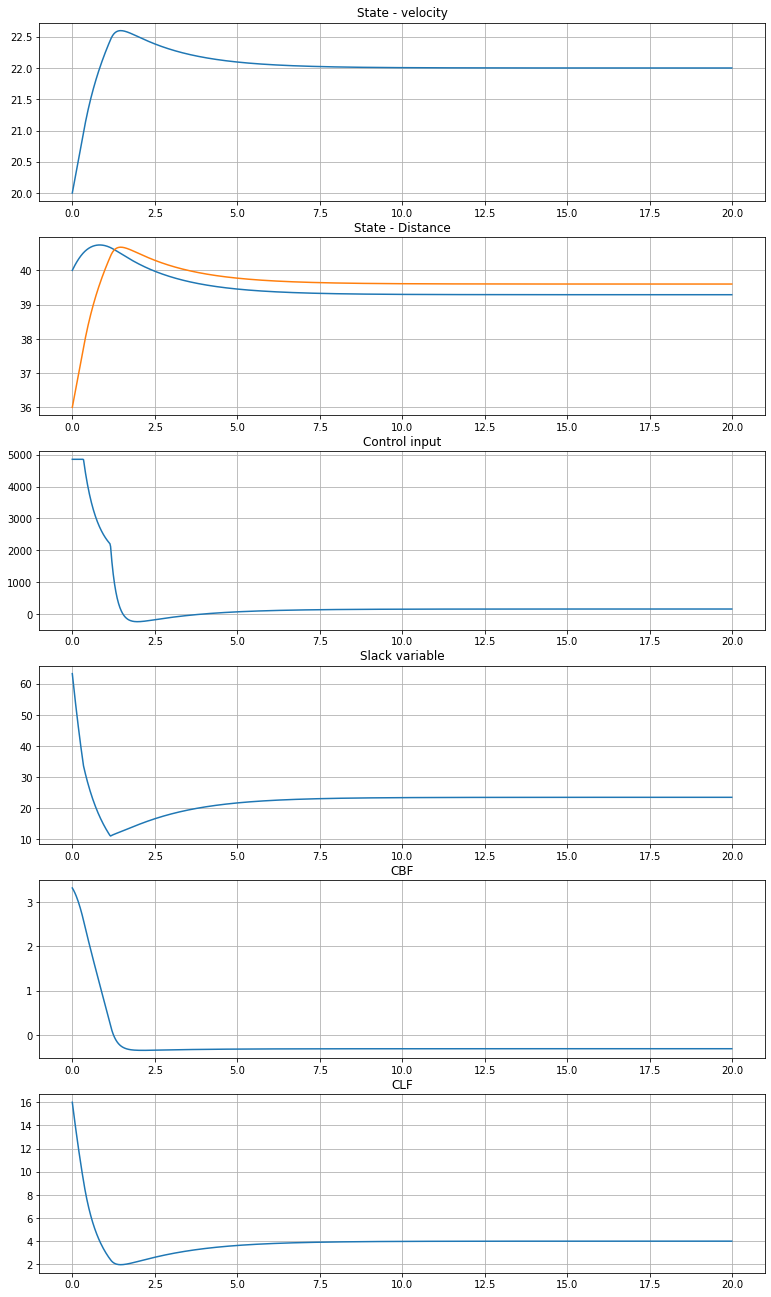

In [64]:
f,ax = plt.subplots(6,1,figsize = (13,23))
t_lns = np.arange(0, simTime, dt)

ax[0].plot(t_lns, np.array(x_lst)[:,1])
ax[0].grid(True)
ax[0].set_title('State - velocity')

ax[1].plot(t_lns, np.array(x_lst)[:,2])
ax[1].grid(True)
ax[1].set_title('State - Distance')

ax[1].plot(t_lns, Th*np.array(x_lst)[:,1])

ax[2].plot(t_lns, np.array(u_lst))
ax[2].grid(True)
ax[2].set_title('Control input')

ax[3].plot(t_lns, np.array(slack_lst))
ax[3].grid(True)
ax[3].set_title('Slack variable')

ax[4].plot(t_lns, np.array(B_lst))
ax[4].grid(True)
ax[4].set_title('CBF')

ax[5].plot(t_lns, np.array(V_lst))
ax[5].grid(True)
ax[5].set_title('CLF')